# Cálculo de energía del gradiente

In [122]:
using DataFrames
using Gadfly
using Cairo
using Compose
using MIToS.PDB
using Chemfiles
using Distributions
set_default_plot_size(40cm, 14cm)

In [49]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [50]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [51]:
function read_ptraj_modes(file, modes_elements, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [52]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [53]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [54]:
function Weighted_Acu(in_y, in_x, bin_count)
    in_y = in_y .^2
    
    # Safety check    
    if length(in_y) != length(in_x)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    bin_size = ceil((maximum(evals_1hvr_apo) - minimum(evals_1hvr_apo)) / bin_count)
    out_y = Array{Float64, 1}(bin_count)
    out_x = collect(1:bin_count) .* bin_size - 0.5 .* bin_size

    for i = 1:bin_count
        edge = bin_size * i
        out_y[i] = sum(in_y[in_x .< edge])
    end
    
    return out_x, out_y
end

Weighted_Acu (generic function with 1 method)

In [104]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831
    
    # Obtengo la 1era y 2da parte de la ecuación
    #pri = d^2 * KB * avgdro * T * 10000 / 2 
    
    #sec = sum(evals.^2 .* gdte.^2)

    return d^2 * 0.5 * KBT * sum(evals.^2 .* gdte.^2) / cte # KJ/mol
end

energia_gdte (generic function with 2 methods)

In [103]:
evals = evals_1hvr_apo
gdte = gdte_whole_1hvr_apo
d = 0.1

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    KB = 1.38064852e-23
    avgdro = 6.0221409e+23
    T = 298
    KBT = 0.593 # 
    cte = 11792.08316093831

d^2 * 0.5 * KBT * sum(evals.^2 .* gdte.^2) / cte # KJ/mol

0.013645997561098048

# Energía

In [105]:
# Preparo variables
points = 21
max = floor(points / 2)
min = -max
main_dir = "/home/german/labo/16/exs/"

KB = 1.38064852e-23
avgdro = 6.0221409e+23
T = 298
KBT = KB * avgdro * 298 / 1000

2.4777090564033073

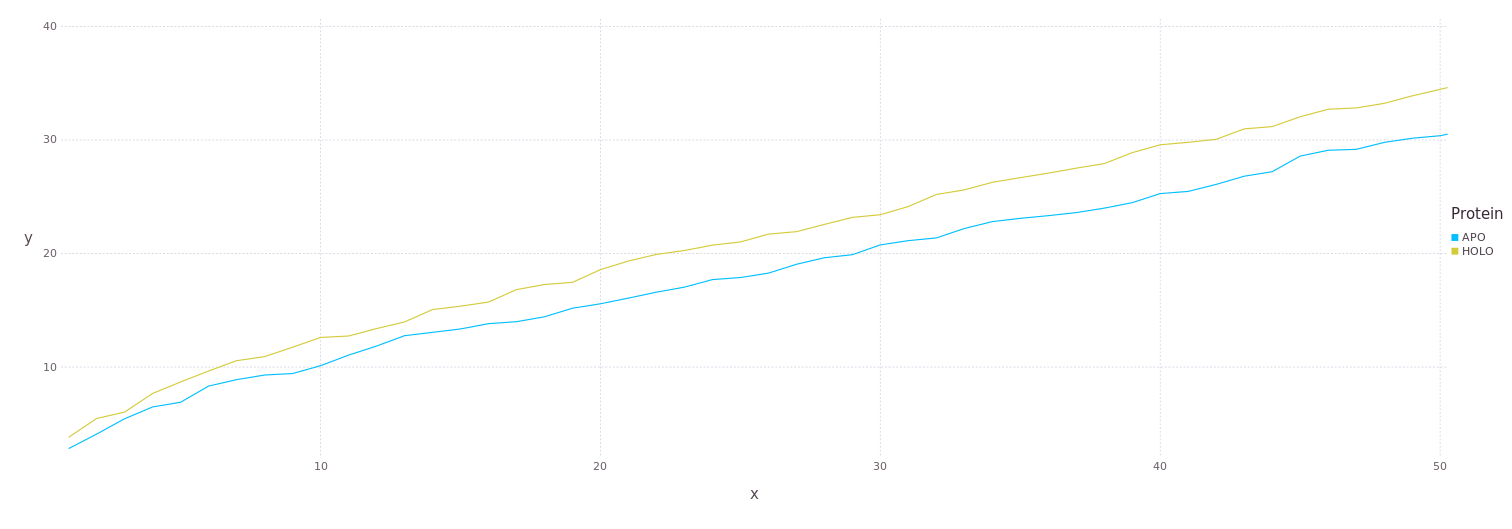

In [106]:
plot(DataFrame(y = [evals_1hvr_apo ; evals_1hvr_hol],
x = [ collect(1:length(evals_1hvr_apo)) ; collect(1:length(evals_1hvr_apo)) ],
Protein = repeat(["APO" ; "HOLO"], inner = [length(evals_1hvr_apo)])), y="y", x="x", color = "Protein",
Geom.line, Coord.cartesian(xmax = 50, ymax = 40))

### 1hvr_apo

In [107]:
pdb_1hvr_apo = read(string(main_dir, "cavities/bu/avg_1hvr_apo.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1hvr_apo = length(pdb_1hvr_apo)
aa3_1hvr_apo = aa_1hvr_apo * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1hvr_apo, evals_1hvr_apo = read_ptraj_modes(string(main_dir, "run/1hvr_apo/pca/modes_1hvr_apo"),
                                    aa3_1hvr_apo);

# Leo gradiente
df_gdte_whole_1hvr_apo = readtable(string(main_dir, "paper/misc/gdte_1hvr_apo"))
gdte_whole_1hvr_apo = convert(Array{Float64,1 }, df_gdte_whole_1hvr_apo[:delta]);

# Obtengo barrido de energías
E_1hvr_apo = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_apo[i] = energia_gdte(evals_1hvr_apo, gdte_whole_1hvr_apo, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_1hvr_apo = convert(Int64, round(sum(gdte_whole_1hvr_apo .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1hvr_apo = sortperm(abs(gdte_whole_1hvr_apo), rev=true)[1:pnumber_gdte_1hvr_apo]
indices_pnum_modes_1hvr_apo = sort(indices_pnum_modes_1hvr_apo);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_1hvr_apo_pnum = gdte_whole_1hvr_apo[indices_pnum_modes_1hvr_apo];
gdte_whole_1hvr_apo_pnum = gdte_whole_1hvr_apo_pnum / norm(gdte_whole_1hvr_apo_pnum)
# Me quedo con las frequencias de los "pnumber" modos.
evals_1hvr_apo_pnum = evals_1hvr_apo[indices_pnum_modes_1hvr_apo];

# Obtengo barrido de energías
E_1hvr_apo_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_apo_pnum[i] = energia_gdte(evals_1hvr_apo_pnum, gdte_whole_1hvr_apo_pnum, disp)
end

# Obtengo barrido de energías
E_1hvr_apo = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_apo[i] = energia_gdte(evals_1hvr_apo, gdte_whole_1hvr_apo, disp)
end

### 1hvr_hol

In [108]:
pdb_1hvr_hol = read(string(main_dir, "cavities/bu/avg_1hvr_hol.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1hvr_hol = length(pdb_1hvr_hol)
aa3_1hvr_hol = aa_1hvr_hol * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1hvr_hol, evals_1hvr_hol = read_ptraj_modes(string(main_dir, "run/1hvr_hol/pca/modes_1hvr_hol"),
                                    aa3_1hvr_hol);

# Leo gradiente
df_gdte_whole_1hvr_hol = readtable(string(main_dir, "paper/misc/gdte_1hvr_hol"))
gdte_whole_1hvr_hol = convert(Array{Float64,1 }, df_gdte_whole_1hvr_hol[:delta]);

# Obtengo barrido de energías
E_1hvr_hol = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_hol[i] = energia_gdte(evals_1hvr_hol, gdte_whole_1hvr_hol, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_1hvr_hol = convert(Int64, round(sum(gdte_whole_1hvr_hol .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1hvr_hol = sortperm(abs(gdte_whole_1hvr_hol), rev=true)[1:pnumber_gdte_1hvr_hol]
indices_pnum_modes_1hvr_hol = sort(indices_pnum_modes_1hvr_hol);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_1hvr_hol_pnum = gdte_whole_1hvr_hol[indices_pnum_modes_1hvr_hol];
gdte_whole_1hvr_hol_pnum = gdte_whole_1hvr_hol_pnum / norm(gdte_whole_1hvr_hol_pnum)
# Me quedo con las frequencias de los "pnumber" modos
evals_1hvr_hol_pnum = evals_1hvr_hol[indices_pnum_modes_1hvr_hol];

# Obtengo barrido de energías
E_1hvr_hol_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_hol_pnum[i] = energia_gdte(evals_1hvr_hol_pnum, gdte_whole_1hvr_hol_pnum, disp)
end

# Obtengo barrido de energías
E_1hvr_hol = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1hvr_hol[i] = energia_gdte(evals_1hvr_hol, gdte_whole_1hvr_hol, disp)
end

### 1m14

In [109]:
pdb_1m14 = read(string(main_dir, "run/1m14/pca/cut_avg_1m14.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1m14 = length(pdb_1m14)
aa3_1m14 = aa_1m14 * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1m14, evals_1m14 = read_ptraj_modes(string(main_dir, "run/1m14/pca/modes_1m14"),
                                    aa3_1m14);

# Leo gradiente
df_gdte_whole_1m14 = readtable(string(main_dir, "paper/misc/gdte_1m14"))
gdte_whole_1m14 = convert(Array{Float64,1 }, df_gdte_whole_1m14[:delta]);

# Obtengo barrido de energías
E_1m14 = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1m14[i] = energia_gdte(evals_1m14, gdte_whole_1m14, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_1m14 = convert(Int64, round(sum(gdte_whole_1m14 .^ 4) .^ -1)) 
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_1m14 = sortperm(abs(gdte_whole_1m14), rev=true)[1:pnumber_gdte_1m14]
indices_pnum_modes_1m14 = sort(indices_pnum_modes_1m14);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_1m14_pnum = gdte_whole_1m14[indices_pnum_modes_1m14];
gdte_whole_1m14_pnum = gdte_whole_1m14_pnum / norm(gdte_whole_1m14_pnum)
# Me quedo con las frequencias de los "pnumber" modos
evals_1m14_pnum = evals_1m14[indices_pnum_modes_1m14];

# Obtengo barrido de energías
E_1m14_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1m14_pnum[i] = energia_gdte(evals_1m14_pnum, gdte_whole_1m14_pnum, disp)
end

# Obtengo barrido de energías
E_1m14 = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_1m14[i] = energia_gdte(evals_1m14, gdte_whole_1m14, disp)
end

### 256l

In [117]:
pdb_256l = read(string(main_dir, "run/256l/pca/cut_avg_256l.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_256l = length(pdb_256l)
aa3_256l = aa_256l * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_256l, evals_256l = read_ptraj_modes(string(main_dir, "run/256l/pca/modes_256l"),
                                    aa3_256l);

# Leo gradiente
df_gdte_whole_256l = readtable(string(main_dir, "paper/misc/gdte_256l"))
gdte_whole_256l = convert(Array{Float64,1 }, df_gdte_whole_256l[:delta]);

# Obtengo barrido de energías
E_256l = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_256l[i] = energia_gdte(evals_256l, gdte_whole_256l, disp)
end

######
# Ahora con los pnum
#####
# Obtengo el pnumber
pnumber_gdte_256l = convert(Int64, round(sum(gdte_whole_256l .^ 4) .^ -1)) 
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes_256l = sortperm(abs(gdte_whole_256l), rev=true)[1:pnumber_gdte_256l]
indices_pnum_modes_256l = sort(indices_pnum_modes_256l);

# Me quedo con los ∇Volumen de los "pnumber" modos y normalizo.
gdte_whole_256l_pnum = gdte_whole_256l[indices_pnum_modes_256l];
gdte_whole_256l_pnum = gdte_whole_256l_pnum / norm(gdte_whole_256l_pnum)
# Me quedo con las frequencias de los "pnumber" modos
evals_256l_pnum = evals_256l[indices_pnum_modes_256l];

# Obtengo barrido de energías
E_256l_pnum = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_256l_pnum[i] = energia_gdte(evals_256l_pnum, gdte_whole_256l_pnum, disp)
end

# Obtengo barrido de energías
E_256l = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    disp = d * 1e-1
    E_256l[i] = energia_gdte(evals_256l, gdte_whole_256l, disp)
end

## Plots

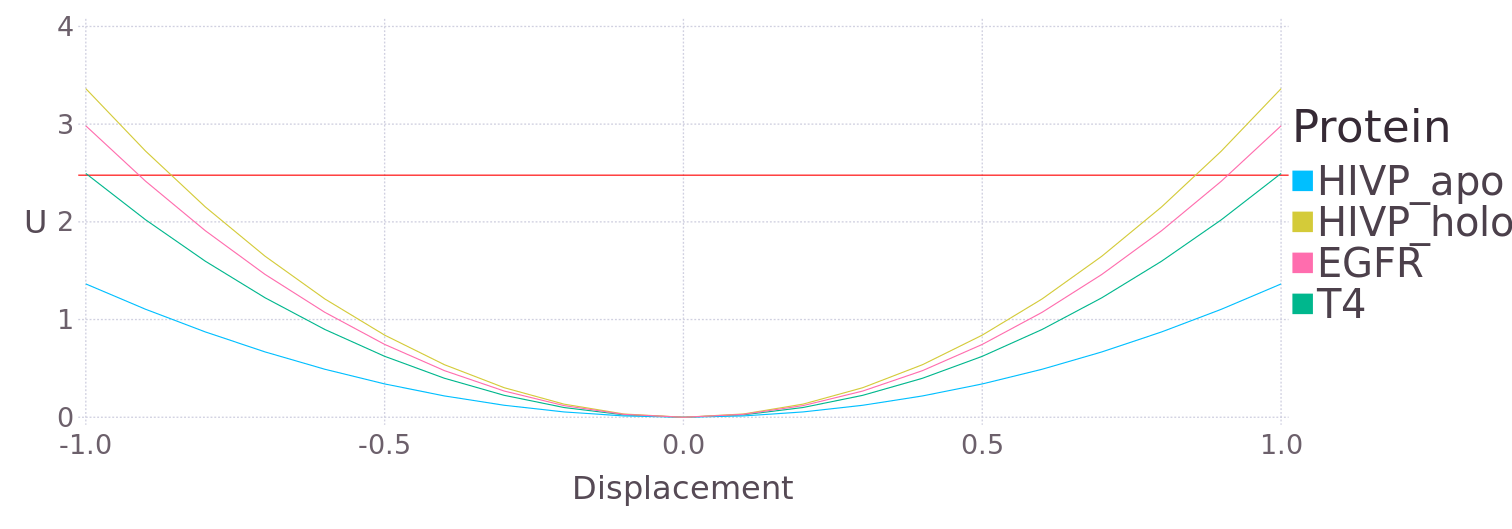

In [111]:
# Compilo en un dataframe.
df_E = DataFrame(U = [ E_1hvr_apo ; E_1hvr_hol ; E_1m14 ; E_256l ],
Displacement = repeat(collect(min:1:max) * 1e-1, outer = [4]), 
Protein = repeat(["HIVP_apo" ; "HIVP_holo" ; "EGFR" ; "T4"], inner = [points]))


pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [KBT], Geom.hline(color = "red"),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

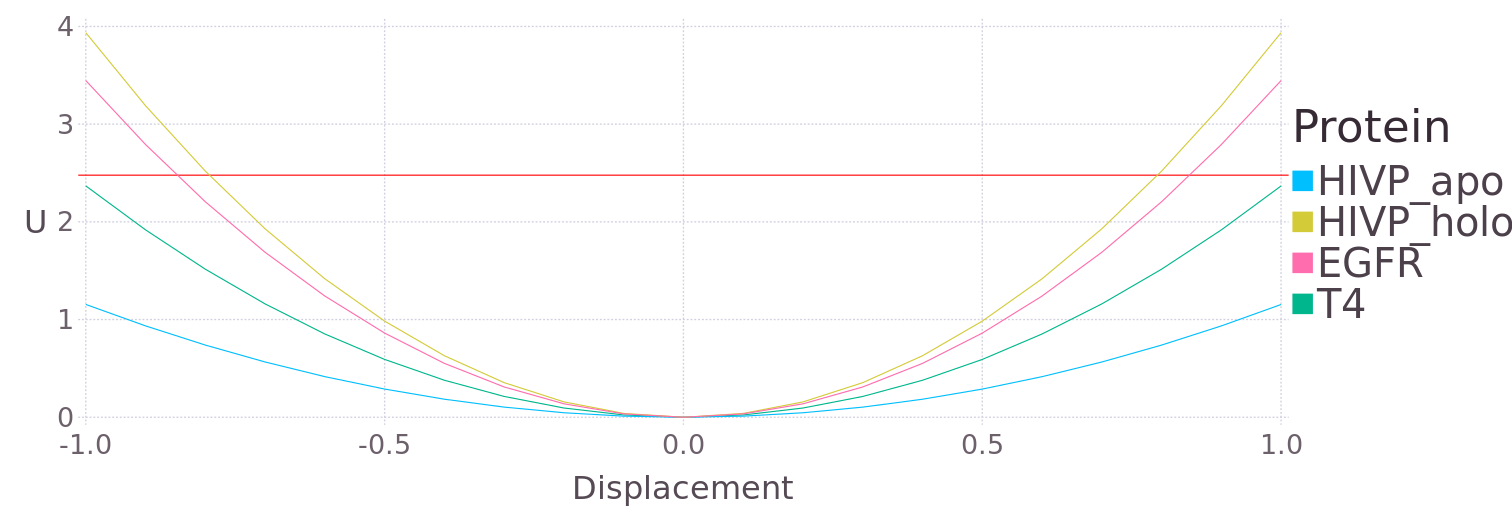

In [118]:
# Compilo en un dataframe.
df_E_pnum = DataFrame(U = [ E_1hvr_apo_pnum ; E_1hvr_hol_pnum ; E_1m14_pnum ; E_256l_pnum ],
Displacement = repeat(collect(min:1:max) * 1e-1, outer = [4]), 
Protein = repeat(["HIVP_apo" ; "HIVP_holo" ; "EGFR" ; "T4"], inner = [points]))


pdf_E_pnum = plot(df_E_pnum, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [KBT], Geom.hline(color = "red"),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

## Acumulados

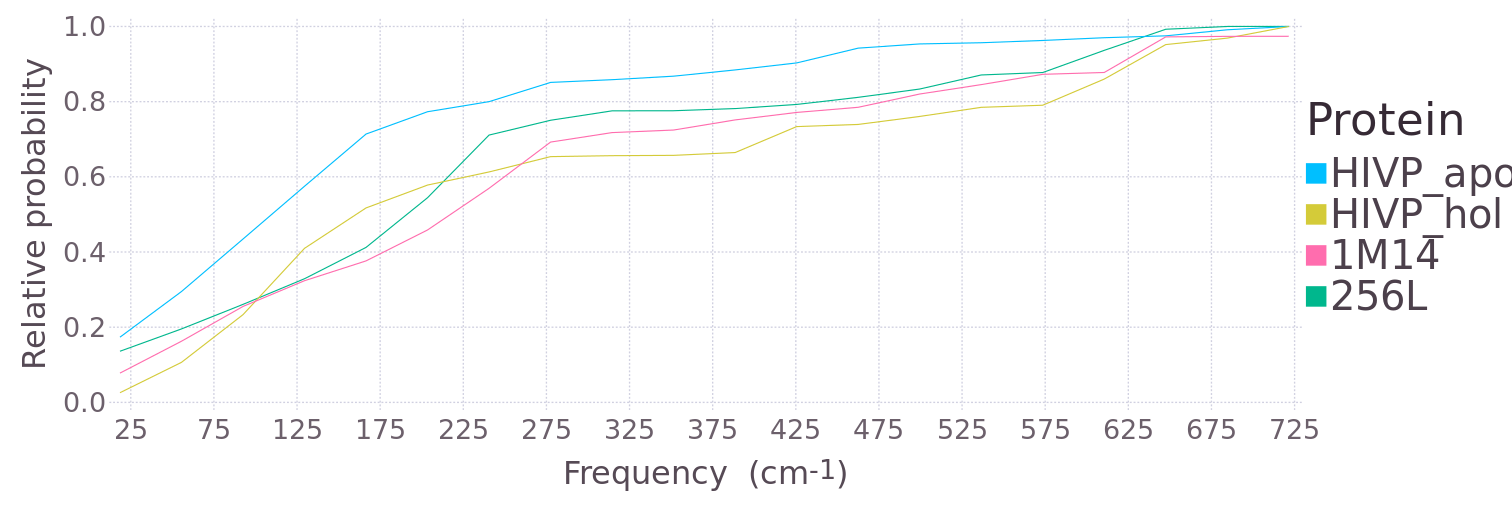

In [119]:
bin_count = 20
acu_x_1hvr_apo, acu_y_1hvr_apo = Weighted_Acu(gdte_whole_1hvr_apo,  evals_1hvr_apo, bin_count)
acu_x_1hvr_hol, acu_y_1hvr_hol = Weighted_Acu(gdte_whole_1hvr_hol,  evals_1hvr_hol, bin_count)
acu_x_1m14, acu_y_1m14 = Weighted_Acu(gdte_whole_1m14,  evals_1m14, bin_count)
acu_x_256l, acu_y_256l = Weighted_Acu(gdte_whole_256l,  evals_256l, bin_count)

df_acu = DataFrame(Fraction = [ acu_y_1hvr_apo ; acu_y_1hvr_hol ; acu_y_1m14 ; acu_y_256l ],
Frequency = [ acu_x_1hvr_apo ; acu_x_1hvr_hol ; acu_x_1m14 ; acu_x_256l ],
Protein = repeat(["HIVP_apo" ; "HIVP_hol" ; "1M14" ; "256L" ], inner = [bin_count]))

pdf_acu = plot(df_acu, y = "Fraction", x = "Frequency", color = "Protein", Geom.line,
Coord.cartesian(ymax = 1.0, xmin = minimum(df_acu[:Frequency])* .9),
Guide.xticks(ticks = collect(25:50:750)), Guide.yticks(ticks = collect(0:0.2:1.)),
Guide.xlabel("Frequency  (cm<sup>-1</sup>)"), Guide.ylabel("Relative probability"),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

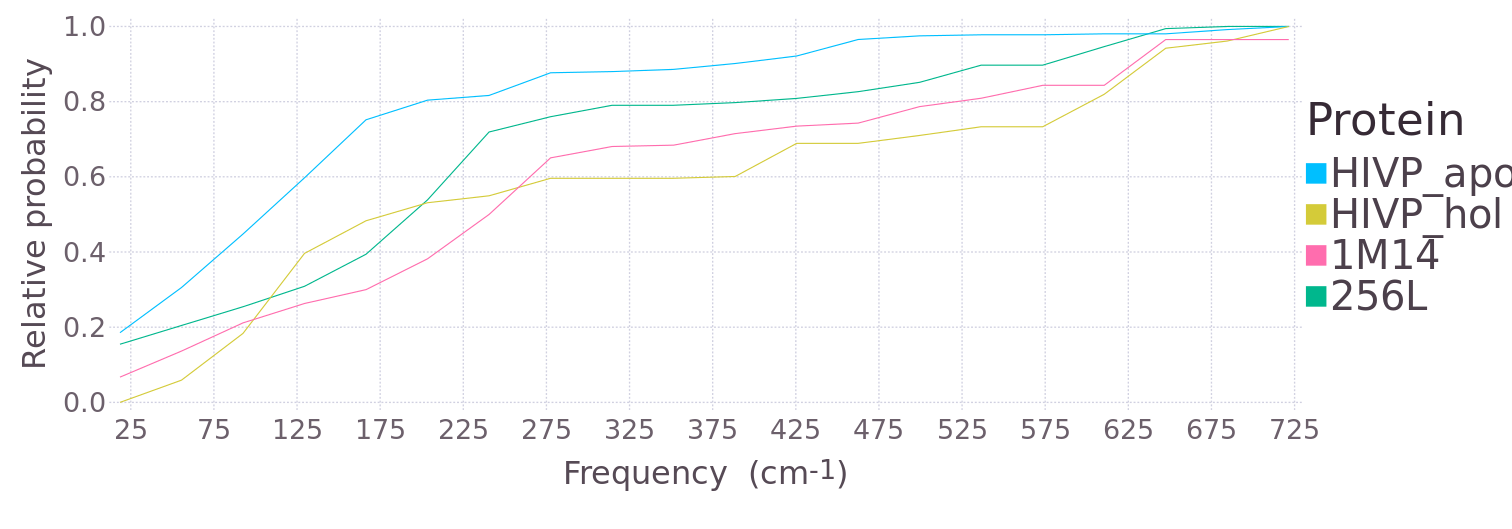

In [120]:
bin_count = 20
acu_x_1hvr_apo_pnum, acu_y_1hvr_apo_pnum = Weighted_Acu(gdte_whole_1hvr_apo_pnum,  evals_1hvr_apo_pnum, bin_count)
acu_x_1hvr_hol_pnum, acu_y_1hvr_hol_pnum = Weighted_Acu(gdte_whole_1hvr_hol_pnum,  evals_1hvr_hol_pnum, bin_count)
acu_x_1m14_pnum, acu_y_1m14_pnum = Weighted_Acu(gdte_whole_1m14_pnum,  evals_1m14_pnum, bin_count)
acu_x_256l_pnum, acu_y_256l_pnum = Weighted_Acu(gdte_whole_256l_pnum,  evals_256l_pnum, bin_count)

df_acu_pnum = DataFrame(Fraction = [ acu_y_1hvr_apo_pnum ; acu_y_1hvr_hol_pnum ; acu_y_1m14_pnum ; acu_y_256l_pnum ],
Frequency = [ acu_x_1hvr_apo_pnum ; acu_x_1hvr_hol_pnum ; acu_x_1m14_pnum ; acu_x_256l_pnum ],
Protein = repeat(["HIVP_apo" ; "HIVP_hol" ; "1M14" ; "256L" ], inner = [bin_count]))

pdf_acu_pnum = plot(df_acu_pnum, y = "Fraction", x = "Frequency", color = "Protein", Geom.line,
Coord.cartesian(ymax = 1.0, xmin = minimum(df_acu[:Frequency])* .9),
Guide.xticks(ticks = collect(25:50:750)), Guide.yticks(ticks = collect(0:0.2:1.)),
Guide.xlabel("Frequency  (cm<sup>-1</sup>)"), Guide.ylabel("Relative probability"),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

In [123]:
lyr_x_ticks = layer(x =  collect(0.0:0.1:0.8), xend = collect(0.0:0.1:0.8),
            y = repeat([-0.005], inner = [9]), yend = repeat([0.005], inner = [9]),
            Geom.segment, Theme(default_color=colorant"Black"))
lyr_y_ticks = layer(y =  collect(0.1:0.1:.3), yend = collect(0.1:0.1:.3),
            x = repeat([-0.003], inner = [3]), xend = repeat([0.003], inner = [3]),
            Geom.segment, Theme(default_color=colorant"Black"))

Guide.annotation(compose(context(), line([(0., 0.), (0.85, 0.), ]),
Compose.stroke("gray"), Compose.fill("gray"))),
Guide.annotation(compose(context(), line([(0., 0.), (0., 0.26), ]),
Compose.stroke("gray"), Compose.fill("gray"))),

(Gadfly.Guide.Annotation(Compose.Context(Measures.BoundingBox{Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}},Tuple{Measures.Length{:w,Float64},Measures.Length{:h,Float64}}}((0.0w,0.0h),(1.0w,1.0h)),Nullable{Compose.UnitBox{S,T,U,V}}(),Nullable{Compose.Rotation{P<:NTuple{N,Measures.Measure}}}(),Nullable{Compose.Mirror}(),List([]),List([Compose.Form{Compose.LinePrimitive{Tuple{Measures.Measure,Measures.Measure}}}([Compose.LinePrimitive{Tuple{Measures.Measure,Measures.Measure}}(Tuple{Measures.Measure,Measures.Measure}[(0.0cx,0.0cy),(0.85cx,0.0cy)])],symbol(""))]),List([Compose.Property{Compose.FillPrimitive}([Compose.FillPrimitive(RGBA{Float64}(0.5019607843137255,0.5019607843137255,0.5019607843137255,1.0))]), Compose.Property{Compose.StrokePrimitive}([Compose.StrokePrimitive(RGBA{Float64}(0.5019607843137255,0.5019607843137255,0.5019607843137255,1.0))])]),0,false,false,false,false,nothing,nothing,0.0,symbol(""))),Gadfly.Guide.Annotation(Compose.Context(Measures.BoundingBox{

## Guardo plots

In [124]:
out_filename_5_fig = string(main_dir, "paper/5-fig/5a-fig.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_E)

out_filename_5_fig = string(main_dir, "paper/5-fig/5a-fig_pnum.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_E_pnum)

out_filename_5_fig = string(main_dir, "paper/5-fig/5b-fig.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_acu)

out_filename_5_fig = string(main_dir, "paper/5-fig/5b-fig_pnum.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_acu_pnum)